In [1]:
import random
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import Transformer
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
import torch.backends.cudnn as cudnn

from tqdm.notebook import tqdm

import wandb

In [2]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

if torch.cuda.is_available(): device = torch.device("cuda")
elif torch.backends.mps.is_available(): device = torch.device("mps")
else: device = torch.device('cpu')

In [3]:
wandb.init()
wandb.run.name = 'transformer'
wandb.run.save()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: qja1998. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [154]:
class GasDataset(Dataset):
    def __init__(self, df, seq_len, out_len, year=None):
        if year is not None:
            self.df = self.df.loc[self.df['year'] == year]
        data_len = df.shape[0] - seq_len - out_len
        data = np.zeros((data_len, 2), dtype=object)
        supply_data = np.array(pd.DataFrame(df.supply, dtype='float32'))
        
        for i in range(len(data)):
            data[i, 0] = supply_data[i:i + seq_len]
            data[i, 1] = supply_data[i + seq_len:i + seq_len + out_len]

        self.data = np.array(data, dtype=object)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.Tensor(self.data[idx, 0])
        dec_input = torch.Tensor(self.data[idx, 1][:-1])
        y = torch.Tensor(self.data[idx, 1][1:])
        
        return x, dec_input, y

In [155]:
class TransformerModel(nn.Module):
    def __init__(self, d_model, seq_len, out_len, nhead, nhid, nlayers, model_type, dropout=0.5):
        super(TransformerModel, self).__init__()
        
        self.model_type = model_type
        self.d_model = d_model

        self.pos_encoder = PositionalEncoding(d_model, dropout)

        if model_type == "enc-dec":
            self.embedding = nn.Linear(1, d_model)
            self.transformer = Transformer(d_model=d_model, nhead=nhead, dim_feedforward=nhid, num_encoder_layers=nlayers, num_decoder_layers=nlayers, dropout=dropout)
            self.linear = nn.Linear(d_model, 1)
        
        else:
            if model_type == "enc":
                encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
                self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)

            elif model_type == "dec":
                encoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
                self.transformer_encoder = nn.TransformerDecoder(encoder_layer, num_layers=nlayers)
            
            self.embedding = nn.Sequential(
                nn.Linear(1, d_model//2),
                nn.ReLU(),
                nn.Linear(d_model//2, d_model)
            )
            
            self.fc =  nn.Sequential(
                nn.Linear(d_model, d_model//2),
                nn.ReLU(),
                nn.Linear(d_model//2, 1),
            )

            self.fc2 = nn.Sequential(
                nn.Linear(seq_len, (seq_len + out_len)//2),
                nn.ReLU(),
                nn.Linear((seq_len + out_len)//2, out_len)
            )

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, tgt, srcmask, tgtmask):
        if self.model_type == "enc-dec":
            src = self.embedding(src) * math.sqrt(self.d_model)
            src = self.pos_encoder(src)
            tgt = self.embedding(tgt) * math.sqrt(self.d_model)
            tgt = self.pos_encoder(tgt)

            output = self.transformer(src.transpose(0,1), tgt.transpose(0,1), srcmask, tgtmask)
            output = self.linear(output)

        else:
            src = self.embedding(src) * math.sqrt(self.d_model)
            src = self.pos_encoder(src)
            output = self.transformer_encoder(src.transpose(0,1), srcmask).transpose(0,1)
            output = self.fc(output)[:,:,0]
            output = self.fc2(output)

        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

In [162]:
seq_len = 14
out_len = 7
train_rate = 0.8
df = pd.read_csv("data/korea/kor_gas_day.csv")
df = df.loc[df['type'] == 'A']
train_len = int(len(df) * train_rate)

df_train, df_val = df.iloc[:train_len], df.iloc[train_len:]
train_dataset = GasDataset(df_train, seq_len, out_len)
train_loader = DataLoader(train_dataset, batch_size=64)

lr = 1e-3
model = TransformerModel(256, 14, 7, 8, 256, 2, 'enc-dec', 0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model.eval()
for batch_idx, (x, dec_input, y) in enumerate(train_loader):
    print(x.shape, dec_input.shape, y.shape)
    x = x.to(device)
    dec_input = dec_input.to(device)
    y = y.to(device)
    src_mask = model.generate_square_subsequent_mask(x.shape[1]).to(device)
    tgt_mask = model.generate_square_subsequent_mask(dec_input.shape[1]).to(device)
    output = model(x, dec_input, src_mask, tgt_mask).transpose(0, 1)
    print(output.shape)
    break

torch.Size([64, 14, 1]) torch.Size([64, 6, 1]) torch.Size([64, 6, 1])
torch.Size([64, 6, 1])


In [164]:
def train(model, train_loader, val_data, optimizer, criterion, epoch):
    model.train()
    for i in tqdm(range(epoch)):
        for batch_idx, (x, dec_input, y) in enumerate(train_loader):
            x = x.to(device)
            dec_input = dec_input.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()
            
            src_mask = model.generate_square_subsequent_mask(x.shape[1]).to(device)
            tgt_mask = model.generate_square_subsequent_mask(dec_input.shape[1]).to(device)
            output = model(x, dec_input, src_mask, tgt_mask).transpose(0, 1)
            
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            wandb.log({
                "epoch": i,
                "Loss": loss,
                'x': x,
                'y': y
            })
        if i % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i, epoch,
                100. * i / epoch, loss.item()))

    if val_data is not None:
        model.eval()
        loss = 0
        true_val = []
        predictions = []
        with torch.no_grad():
            for batch_idx, (x, dec_input, y) in enumerate(val_data):
                
                x = x.unsqueeze(0).to(device)
                dec_input = dec_input.to(device)
                
                y = y.unsqueeze(0).to(device)
                src_mask = model.generate_square_subsequent_mask(x.shape[1]).to(device)
                tgt_mask = model.generate_square_subsequent_mask(dec_input.shape[1]).to(device)
                
                output = model(x, dec_input, src_mask, tgt_mask).transpose(0, 1)

                loss += criterion(output, y)
                for i in y.squeeze().cpu().numpy():
                    true_val.append(float(i))
                for i in output.squeeze().cpu().numpy():
                    predictions.append(float(i))
        

        print('\nTest set: Average loss: {:.4f}'.format(loss / len(val_data)))
        
        plt.figure(figsize=(30,15))
        x = np.arange(len(true_val))
        plt.subplot(411)
        plt.plot(x, true_val, label='true', c='blue')
        plt.plot(x, predictions, label='predictions', c='red')
        plt.legend()

        true_val_cumsum = np.cumsum(true_val)

        tmp1 = predictions[:]
        for i, v in enumerate(true_val_cumsum[:-1]):
            tmp1[i + 1] = v + tmp1[i + 1]
            
        plt.subplot(412)
        plt.plot(x, true_val_cumsum, label='true', c='blue')
        plt.plot(x, predictions, label='predictions', c='red')
        plt.plot(x, np.cumsum(tmp1), label='self cumsum', c='orange')
        plt.legend()

        self_predictions = []
        x = val_data[0][0].unsqueeze(0).to(device)
        dec_input = val_data[0][1].usqueeze(0).to(device)
        
        with torch.no_grad():
            for i, (_, _, true_y) in enumerate(val_data):
                x = x.to(device)
                y = y.to(device)
                src_mask = model.generate_square_subsequent_mask(x.shape[1]).to(device)
                tgt_mask = model.generate_square_subsequent_mask(y.shape[1]).to(device)
                
                output = model(x, y, src_mask, tgt_mask).transpose(0, 1)
                
                tmp = x[:, 1:]
                x = torch.cat([tmp, output[0]], dim=1)

                tmp2 = 

                loss += criterion(output, true_y.to(device))
                for i in output.squeeze().cpu().numpy():
                    self_predictions.append(float(i))

        print('\nTest set: Average loss: {:.4f}'.format(loss / len(val_data)))
        x = np.arange(len(true_val))
        plt.subplot(413)
        plt.plot(x, true_val, label='true', c='blue')
        plt.plot(x, self_predictions, label='predictions', c='red')
        plt.legend()
        
        tmp2 = self_predictions[:]
        for i, v in enumerate(true_val_cumsum[:-1]):
            tmp2[i + 1] = v + tmp2[i + 1]
        
        plt.subplot(414)
        plt.plot(x, true_val_cumsum, label='true', c='blue')
        plt.plot(x, self_predictions, label='predictions', c='red')
        plt.plot(x, np.cumsum(tmp2), label='self cumsum', c='orange')
        plt.legend()

        return true_val, true_val_cumsum, predictions, self_predictions

In [165]:
seq_len = 14
out_len = 7
train_rate = 0.8

epochs = 1
batch_szie = 512

df = pd.read_csv("data/korea/kor_gas_day.csv")
df = df.loc[df['type'] == 'A']
df.loc[:, ['supply']] = df.loc[:, ['supply']].astype(float).diff()
df = df[1:]
train_len = int(len(df) * train_rate)

df_train, df_val = df.iloc[:train_len], df.iloc[train_len:]
train_dataset = GasDataset(df_train, seq_len, out_len)
train_loader = DataLoader(train_dataset, batch_size=batch_szie, shuffle=True)

val_dataset = GasDataset(df_val, seq_len, out_len)

In [166]:
train_dataset[-13]

(tensor([[-106.3304],
         [ -52.0361],
         [ 141.3986],
         [  12.6845],
         [ -22.8547],
         [  12.8625],
         [  -0.9318],
         [ -88.6065],
         [ -41.3547],
         [ 124.0087],
         [   8.5159],
         [ -19.6581],
         [  11.3712],
         [  15.0404]]),
 tensor([[-83.2923],
         [-27.0278],
         [-31.6217],
         [-40.9496],
         [-36.0041],
         [ 25.1197]]),
 tensor([[-27.0278],
         [-31.6217],
         [-40.9496],
         [-36.0041],
         [ 25.1197],
         [ 58.0590]]))

In [167]:
seq_len = 14
out_len = 7
train_rate = 0.1
df = pd.read_csv("data/korea/kor_gas_day.csv")
df = df.loc[df['type'] == 'A']
train_len = int(len(df) * train_rate)

lr = 1e-3
model = TransformerModel(256, 14, 7, 8, 256, 2, 'enc-dec', 0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  0%|          | 0/1 [00:00<?, ?it/s]

Train Epoch: 1 [0/1 (0%)]	Loss: 13419.997070

Test set: Average loss: 22053.4492
torch.Size([1, 14, 1]) torch.Size([1, 7, 1])
torch.Size([1, 7, 1]) torch.Size([1, 7, 1])
torch.Size([1, 14, 1]) torch.Size([1, 1, 7, 1])


/Users/kwon/miniconda3/envs/co2/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([7, 1])) that is different to the input size (torch.Size([1, 7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


AssertionError: query should be unbatched 2D or batched 3D tensor but received 4-D query tensor

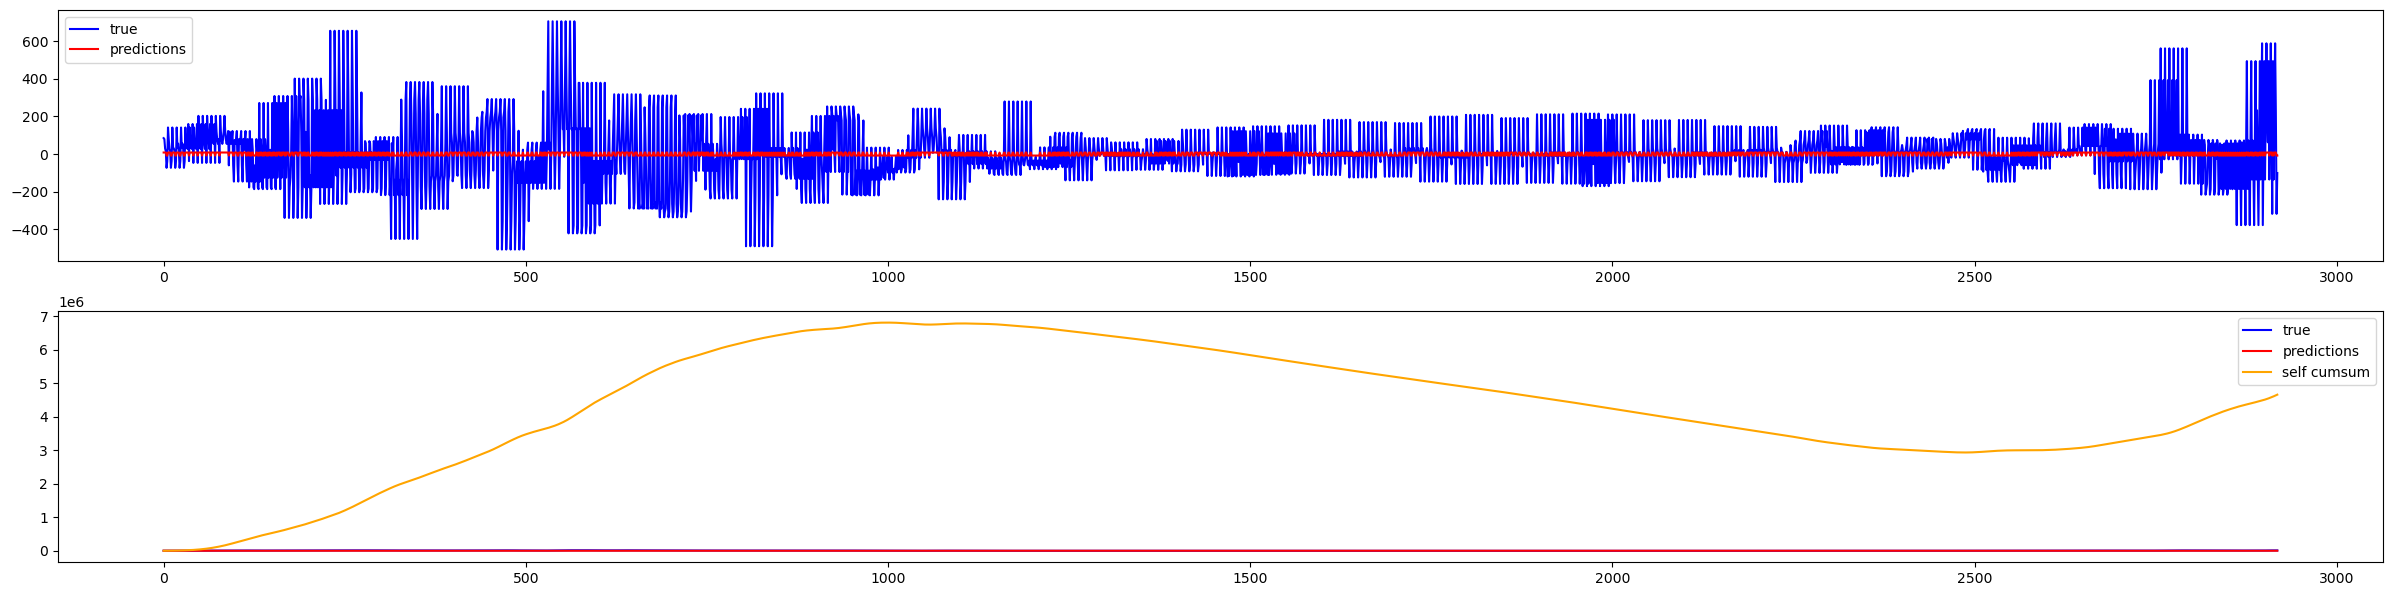

In [148]:
results = train(model, train_loader, val_dataset, optimizer, criterion, epochs)
true_val, true_val_cumsum, predictions, self_predictions = results[:]